In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
from gradientboost import GradientBoost

In [3]:
data = pd.read_json('data/data.json')

In [8]:
y = (data['acct_type'].apply(lambda x: x[:5]) == 'fraud' ).astype(int)
X = data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
gb = GradientBoost()

In [14]:
gb.fit(X_train)

In [15]:
gb.score()

-0.0716405704523537

In [16]:
y_proba = gb.predict_proba(X_test.iloc[:,1:])[:,1]

In [17]:
# y = (X_test['acct_type'].apply(lambda x: x[:5]) == 'fraud' ).astype(int).values

In [18]:
y_hat = gb.predict(X_test.iloc[:,1:])

In [19]:
def conf_mat(y,y_hat):
    """
    input
    y: actual values
    y_hat: predicted values
    
    output:
    confusion matrix
    """
    y = y.astype(bool)
    y_hat = y_hat.astype(bool)
    
    tp = (y & y_hat).sum()
    fp = (~y & y_hat).sum()
    fn = (y & ~y_hat).sum()
    tn = (~y & ~y_hat).sum()
    
    cmat = np.array([[tp, fp],
                     [fn, tn]])
    
    return cmat

In [20]:
conf_mat(y_test,y_hat)

array([[ 269,   23],
       [  60, 3233]])

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

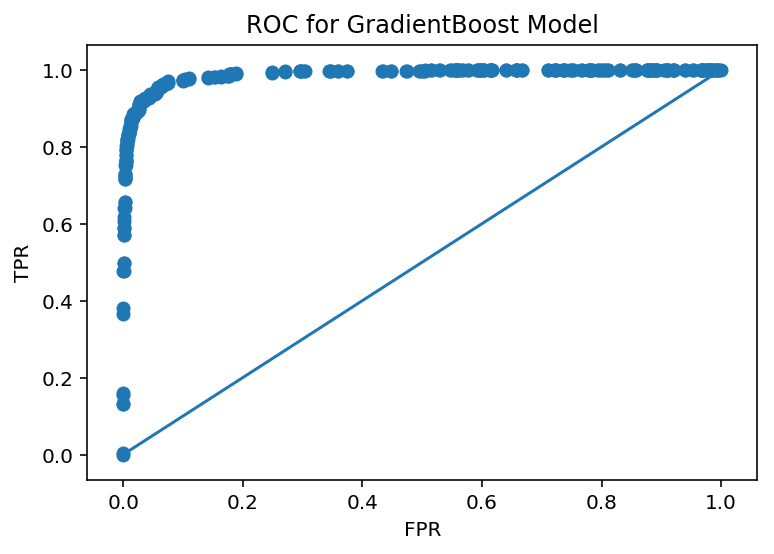

In [22]:
plt.scatter(x = fpr, y = tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for GradientBoost Model')
plt.show()

In [23]:
roc_auc_score(y_test, y_proba)

0.9884898023195896

Cost benefit matrix:

TP: 10 (maybe get more business?)
FP: -10 (inconvenient)
FN: -100 (very bad)
TN: 0 (no change)


In [24]:
cbm = np.array([[10,-10],[-100,0]])

In [25]:
def cost_benefit(y, y_proba, cost_benefit_matrix, n_thresholds = 200):
    thresholds = np.linspace(0,1,n_thresholds)
    costs = []
    for threshold in thresholds:
        y_hat = y_proba > threshold
        cmat = conf_mat(y, y_hat)
        cost = (cmat * cost_benefit_matrix).sum()
        costs.append(cost)
    return costs, thresholds
    

In [26]:
costs, t_holds = cost_benefit(y_test,y_proba, cbm)

Text(0, 0.5, 'cost fuction')

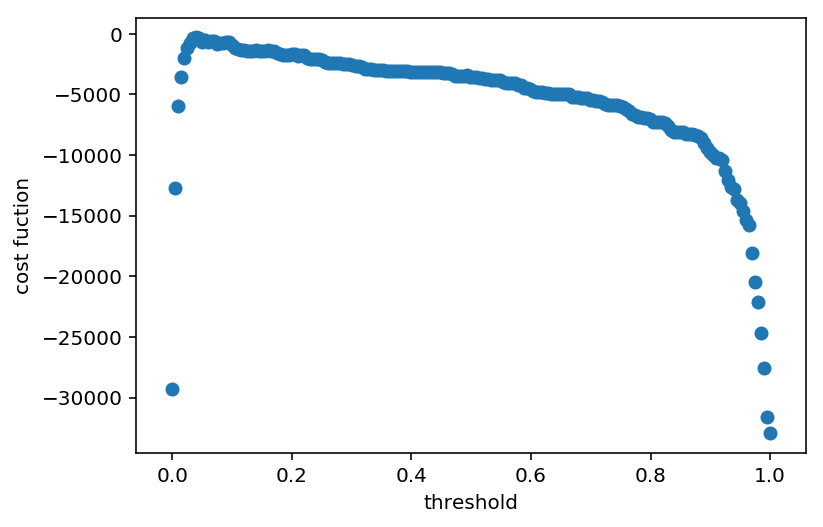

In [27]:
plt.scatter(x = t_holds, y = costs)
plt.xlabel('threshold')
plt.ylabel('cost fuction')

In [36]:
t_hold = t_holds[np.argmax(costs)]

In [47]:
cm = conf_mat(y_test,(y_proba > t_hold))
cm

array([[ 316,  216],
       [  13, 3040]])

In [53]:
print ('Model detects {0:.2f}% of Fraud'.format(100*cm[0,0]/(cm[0,0] + cm[1,0])))
print ('False Positive Rate is {0:.2f}%'.format(100*cm[0,1]/(cm[0,1]+cm[1,1])))

Model detects 96.05% of Fraud
False Positive Rate is 6.63%


(0, 0.08)

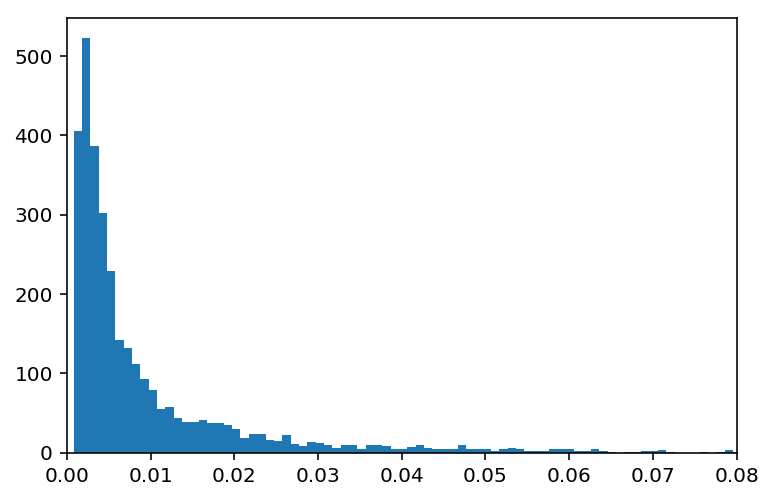

In [57]:
plt.hist(y_proba, bins = 1000)
plt.xlim((0,0.08))

In [98]:
cm = conf_mat(y_test,(y_proba >0.02))
print(cm)
print ('Model detects {0:.2f}% of Fraud'.format(100*cm[0,0]/(cm[0,0] + cm[1,0])))
print ('False Positive Rate is {0:.2f}%'.format(100*cm[0,1]/(cm[0,1]+cm[1,1])))

[[ 323  468]
 [   6 2788]]
Model detects 98.18% of Fraud
False Positive Rate is 14.37%
